Import required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
!piif "google.colab" in str(get_ipython()):
!pip install git+https://github.com/ourownstory/neural_prophet.git
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")


Read in and inspect monthly referral numbers

In [ ]:
df = pd.read_csv("/content/PET referrals monthly.csv")
df.info()
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      42 non-null     object
 1   y       42 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 800.0+ bytes


,ds,y
0,2019-04,345
1,2019-05,441
2,2019-06,398
3,2019-07,468
4,2019-08,441


,ds,y
37,2022-05,496
38,2022-06,446
39,2022-07,475
40,2022-08,457
41,2022-09,484


Create dataframe appropriately formatted for the NeuralProphet algorithm and split into train and test sets with the test set being the last 6 months

In [ ]:
df['ds'] = pd.DatetimeIndex(df['ds'])
Y_train = df[:-6]
Y_test = df[-6:]
df.info()
display(df.head(8))
display(df.tail(8))
display(Y_train.tail(8))
display(Y_test.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      42 non-null     datetime64[ns]
 1   y       42 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 800.0 bytes


,ds,y
0,2019-04-01,345
1,2019-05-01,441
2,2019-06-01,398
3,2019-07-01,468
4,2019-08-01,441
5,2019-09-01,484
6,2019-10-01,472
7,2019-11-01,411


,ds,y
34,2022-02-01,456
35,2022-03-01,569
36,2022-04-01,455
37,2022-05-01,496
38,2022-06-01,446
39,2022-07-01,475
40,2022-08-01,457
41,2022-09-01,484


,ds,y
28,2021-08-01,409
29,2021-09-01,454
30,2021-10-01,428
31,2021-11-01,494
32,2021-12-01,444
33,2022-01-01,536
34,2022-02-01,456
35,2022-03-01,569


,ds,y
36,2022-04-01,455
37,2022-05-01,496
38,2022-06-01,446
39,2022-07-01,475
40,2022-08-01,457
41,2022-09-01,484


Plot the whole dataset

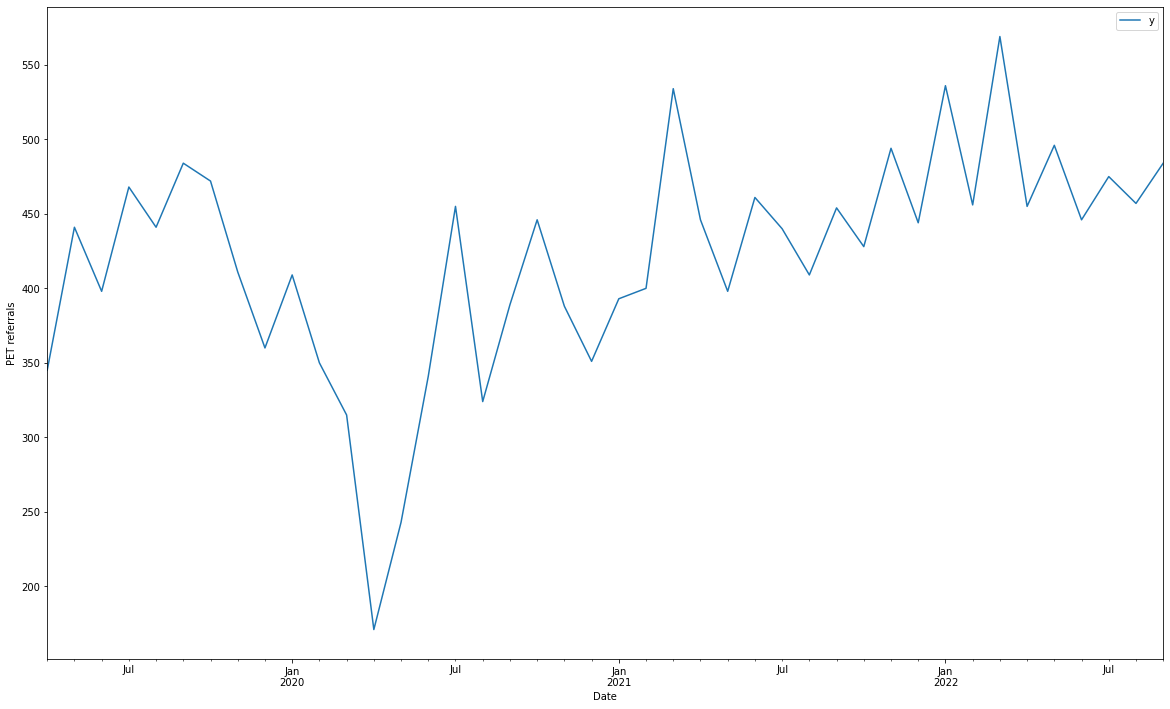

In [ ]:
ax = df.set_index('ds').plot(figsize=(20, 12))
ax.set_ylabel('PET referrals')
ax.set_xlabel('Date')

plt.show()

define covid lockdown period as an event to feed into the the alforithm

In [ ]:
covid = pd.DataFrame(
    {
        "event": "lockdown",
        "ds": pd.to_datetime(["2020-03-01", "2020-04-01", "2020-05-01"]
        ),
    }
)

covid

,event,ds
0,lockdown,2020-03-01
1,lockdown,2020-04-01
2,lockdown,2020-05-01


Train NeuralProphet algorithm with lockdown added as an event

In [ ]:
m = NeuralProphet(ar_reg=1, loss_func="MAE")
m = m.add_events(["lockdown"])
df_with_events = m.create_df_with_events(df, covid)
Y_train_with_events = m.create_df_with_events(Y_train, covid)
Y_test_with_events = m.create_df_with_events(Y_test, covid)
metrics = m.fit(df_with_events, freq='M', validation_df=Y_test_with_events, progress="plot", epochs=500)

inspect the trained metrics

In [ ]:
metrics

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,246.895218,319.699219,0.680495,0.0,0,181.972183,238.915955,0.381656,0.0
1,246.065933,318.892212,0.678210,0.0,1,193.309250,257.825653,0.392534,0.0
2,245.242935,318.059296,0.675942,0.0,2,190.095322,250.941483,0.385826,0.0
3,244.357346,317.204376,0.673503,0.0,3,198.345413,259.670044,0.416993,0.0
4,243.422867,316.296997,0.670929,0.0,4,185.029953,245.873764,0.385163,0.0
...,...,...,...,...,...,...,...,...,...
495,2.344783,4.139144,0.006482,0.0,495,15.019544,24.882950,0.030372,0.0
496,2.343348,4.138550,0.006478,0.0,496,15.687343,26.977873,0.032077,0.0
497,2.342606,4.138368,0.006476,0.0,497,15.358083,27.410368,0.031781,0.0
498,2.342326,4.138380,0.006475,0.0,498,16.870178,28.050804,0.033388,0.0


Plot the component parameters resulting from the trained model

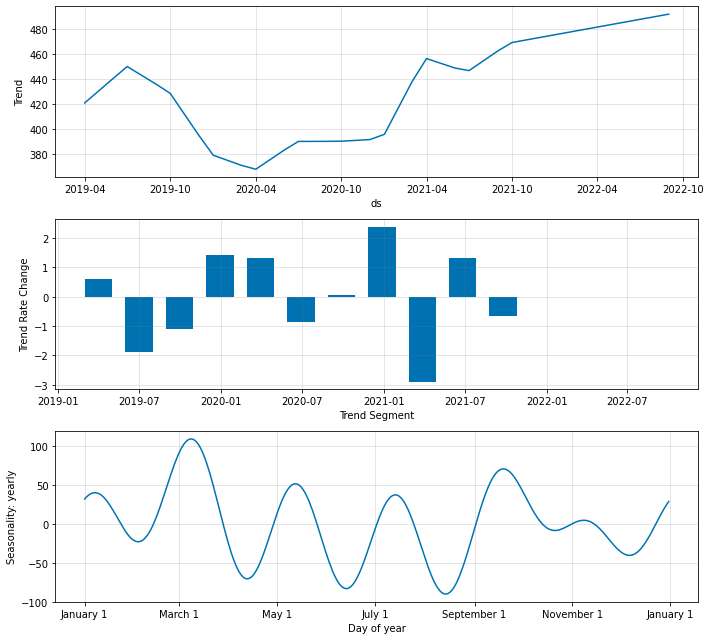

In [ ]:
fig_param = m.plot_parameters()

Make and plot the predicitons adainst actual referral values for the training data

Predicting: 3it [00:00, ?it/s]

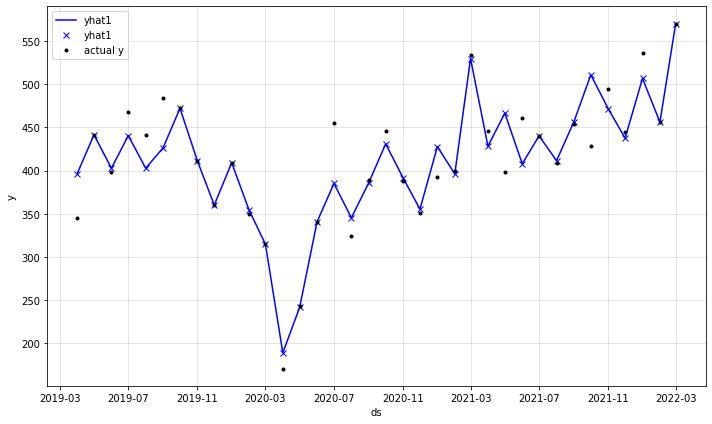

In [ ]:
train_forecast = m.predict(Y_train_with_events)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(train_forecast)

Plot the component parameters for the predictions on the training data

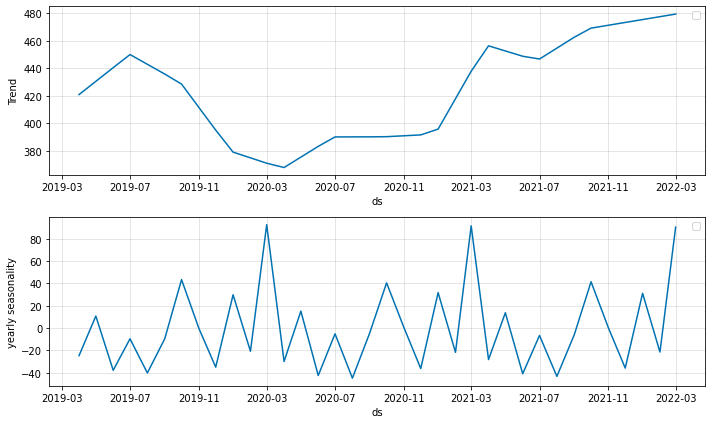

In [ ]:
fig_components = m.plot_components(train_forecast)

Make and plot the predicitons against actual referral values for the test data

Predicting: 3it [00:00, ?it/s]

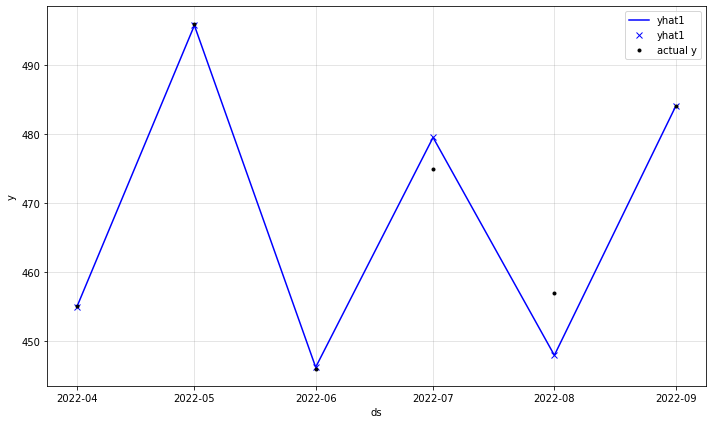

In [ ]:
test_forecast = m.predict(Y_test_with_events)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(test_forecast)

Plot the component parameters for the predictions on the test data

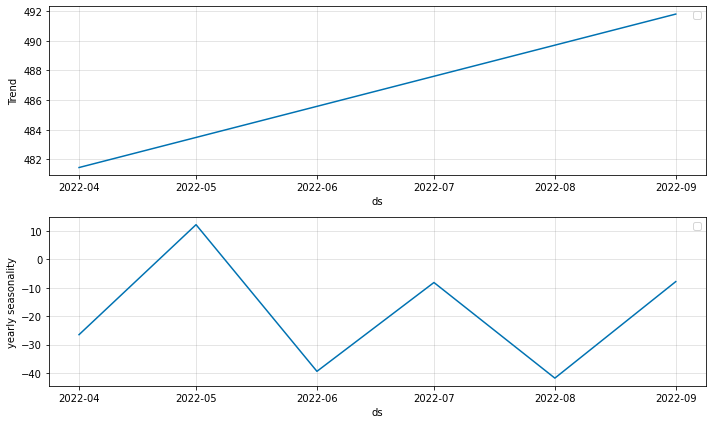

In [ ]:
fig_components = m.plot_components(test_forecast)


Make and plot future predcictions for a time horizon of 12 months after the end of the test data

Predicting: 3it [00:00, ?it/s]

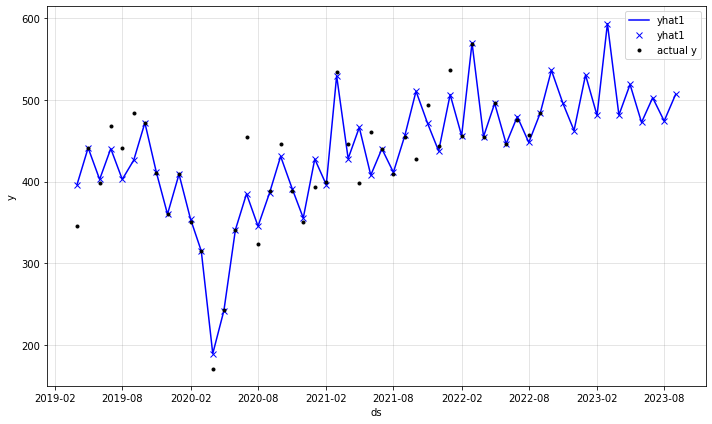

In [ ]:
future = m.make_future_dataframe(df_with_events, periods=12, n_historic_predictions=len(df))
forecast = m.predict(future)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig_forecast = m.plot(forecast)